In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np

# Specify the path to your .pkl file
file_path = 'smac2_training_results.pkl'

# Load the data from the .pkl file
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)



In [2]:
experiment_names = ["protoss_5_vs_5", "zerg_5_vs_5", "terran_5_vs_5", "protoss_10_vs_10", "zerg_10_vs_10", "terran_10_vs_10", "protoss_20_vs_20", "zerg_20_vs_20",
                    "terran_20_vs_20", "protoss_10_vs_11", "zerg_10_vs_11", "terran_10_vs_11", "protoss_20_vs_23", "zerg_20_vs_23", "terran_20_vs_23"]

In [3]:
# Now, 'loaded_data' contains the data from the .pkl file
QMIX_data = {}
for key,value in loaded_data.items():
    for k2, v2 in value.items():
        if k2 == "QMIX":
            QMIX_data[key] = {k2: v2}




# Plotting results for an arbitrary number of steps

In [4]:
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
import traceback

[11, 19, 22, 24, 34, 36, 37, 38, 46, 48, 49, 50, 55, 56, 58, 59, 61, 63, 70, 75, 88, 93, 98, 101, 106, 110, 120, 121, 125, 142, 143, 147, 148, 149, 152, 168, 179, 180, 186, 193, 195, 199, 205, 207, 211, 213, 215, 216, 219, 220, 237, 239, 240, 246, 252, 258, 261, 263, 264, 265, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 26

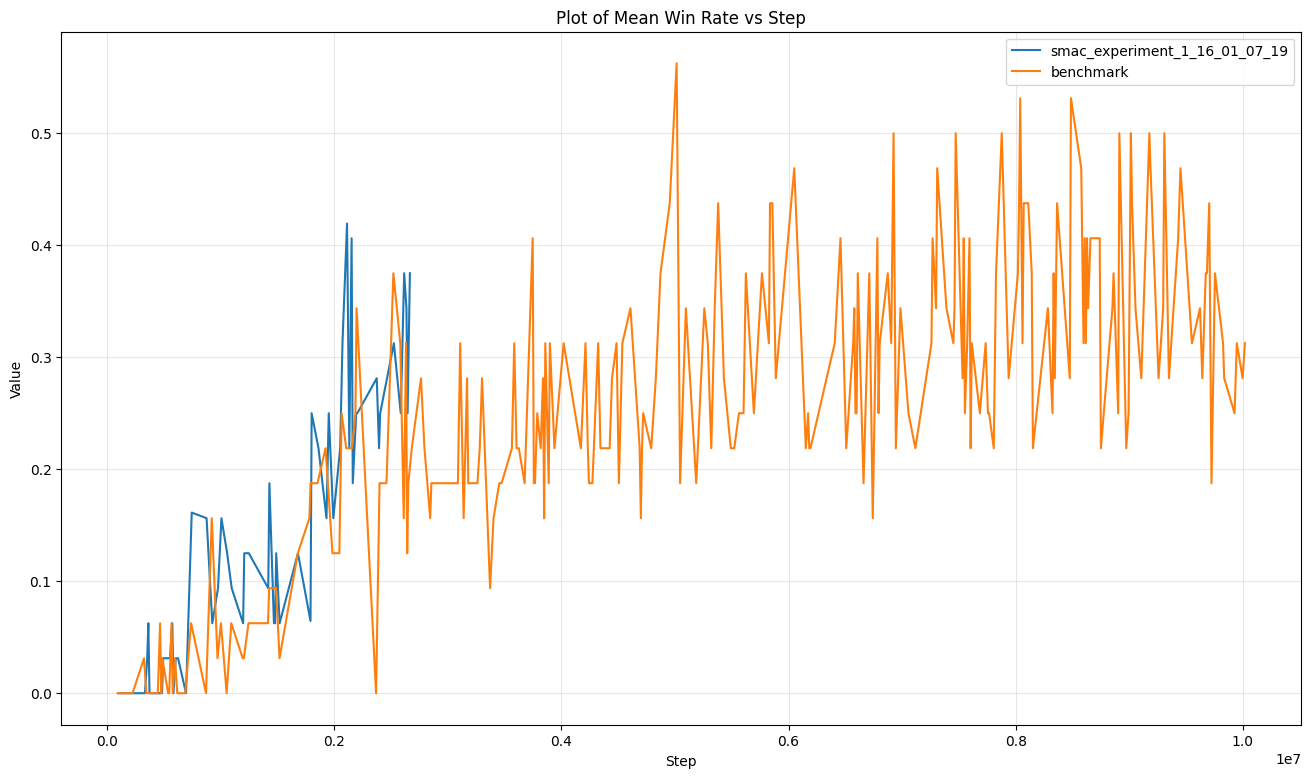

In [23]:
experiment_name = "protoss_10_vs_11"
to_plot = "mean_test_win_rate" # mean_test_win_rate mean_test_return
df_benchmark = pd.DataFrame(QMIX_data[experiment_name]["QMIX"][2])

def get_tb_results(experiment_name):
    logdir = f"./results/{experiment_name}/tb_logs/"
    event_acc = event_accumulator.EventAccumulator(logdir)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']
    get = "test_avg_win_rate"
    win_rate_tag = next(s for s in tags if get in s)


    # # Create an empty DataFrame to store the data
    tag_values = [(event.step, event.value) for event in event_acc.Scalars(win_rate_tag)]
    df = pd.DataFrame(tag_values, columns=['Step', "Value"])
    return df


# Load CSV file into a Pandas DataFrame
# experiments_to_plot = ["smac_experiment_1_14_01_11_56", "smac_experiment_1_15_01_07_37"]
experiments_to_plot = ["smac_experiment_1_16_01_07_19"]

# df_noisynet = get_tb_results("smac_experiment_1_14_01_11_56")
# df_ep_greedy = get_tb_results("smac_experiment_1_15_01_07_37")

# Set the predetermined number
predetermined_number = 10050000


# Assuming your CSV has headers, you can reference columns by their names
x_column = 'Step'  # Replace with the actual name of the second column
y_column = 'Value'   # Replace with the actual name of the third column



  # Replace with your predetermined number

# Find the maximum step value less than the predetermined number
max_step_less_than_predetermined = df_benchmark[df_benchmark['step'] < predetermined_number]['step'].max()

# max_step_less_than_predetermined = df_noisynet[df_noisynet['Step'] < predetermined_number]['Step'].max()
# max_step_less_than_predetermined = df_ep_greedy[df_ep_greedy['Step'] < predetermined_number]['Step'].max()


# Filter the DataFrame based on the condition (step less than max_step_less_than_predetermined)
filtered_df_benchmark = df_benchmark[df_benchmark['step'] <= max_step_less_than_predetermined]

plt.figure(figsize=(16,9))
try:
    for exp in experiments_to_plot:
        df = get_tb_results(exp)
        max_step = df[df['Step'] < predetermined_number]['Step'].max()
        filtered_df = df[df['Step'] <= max_step]
        closest_indices = np.searchsorted(filtered_df['Step'], filtered_df_benchmark['step'], side="left")
        sub_from = closest_indices[-1]
        new_indicies = [x - 1 if x == sub_from else x for x in closest_indices]
        # print(new_indicies)
        # print(filtered_df)
        filtered_df = filtered_df.iloc[new_indicies]
        plt.plot(filtered_df[x_column], filtered_df[y_column], label = exp)
except Exception as e:
    traceback.print_exc()

plt.plot(filtered_df_benchmark['step'], filtered_df_benchmark[to_plot], label = "benchmark")


# filtered_df_noisynet = df_noisynet[df_noisynet['Step'] <= max_step_less_than_predetermined]
# filtered_df_ep_greedy = df_ep_greedy[df_ep_greedy['Step'] <= max_step_less_than_predetermined]

# Filter my data to only plot points that are very close in x-value to the benchmark
# closest_indices = np.searchsorted(filtered_df_noisynet['Step'], filtered_df_benchmark['step'], side="left")
# closest_indices = np.searchsorted(filtered_df_ep_greedy['Step'], filtered_df_benchmark['step'], side="left")


# filtered_df_noisynet = filtered_df_noisynet.iloc[closest_indices]
# filtered_df_ep_greedy = filtered_df_ep_greedy.iloc[closest_indices]




# filtered_df
# Plot the data

# plt.plot(filtered_df_benchmark['step'], filtered_df_benchmark[to_plot], label = "benchmark")
# plt.plot(filtered_df_noisynet[x_column], filtered_df_noisynet[y_column], label = "noisynet")
# plt.plot(filtered_df_ep_greedy[x_column], filtered_df_ep_greedy[y_column], label = "epsilon_greedy")

plt.legend()
plt.title(f"{experiment_name}: {to_plot}")
plt.grid(alpha = 0.3)

# Plot my results
# # Create a scatter plot


# Add labels and title
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title('Plot of Mean Win Rate vs {}'.format(x_column))



plt.show()


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# filtered_df

# Plotting all results for QMIX seed 0

In [6]:
# types = ["mean_test_return", "mean_test_win_rate"]
# for name in experiment_names:
#     df = pd.DataFrame(QMIX_data[name]["QMIX"][0])
    
#     for type in types:
#         # Assuming df is your DataFrame
#         # Replace 'col1' and 'col2' with your actual column names
#         plt.figure(figsize=(16,9))

#         # Plotting
#         plt.plot(df['step'], df[type], label = type)

#         # Adding labels and title
#         plt.xlabel('Step')
#         plt.ylabel(type)
#         plt.title(f"{name}: {type}")
#         plt.grid(alpha = 0.3)
#         plt.legend()

#         ax = plt.gca()
#         ax.xaxis.set_major_locator(MultipleLocator(1000000))
#         ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000000)))

#         # Display the plot
#         plt.savefig(f"figures/{name}.pdf")


# Plotting my own results

In [7]:
import pandas as pd
import matplotlib.pyplot as plt



In [8]:
held = 13321
won = 13321-5

print(won/held)

0.9996246528038436
